# No individual differences

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf


INFO:bayesflow:Using backend 'jax'

### Simulator

In [2]:
def prior():
    alpha = np.random.beta(a=1, b=1)
    beta = np.random.beta(a=1, b=1)
    return dict(alpha=alpha, beta=beta)

def likelihood(alpha, beta, t=np.array([1, 2, 4, 7, 12, 21, 35, 59, 99])):
    theta = np.exp(-alpha*t) + beta
    theta = np.clip(theta, a_min=0, a_max=1)

    k = np.random.binomial(n=18, p=theta, size=(3, len(theta)))
    return dict(k=k)

simulator = bf.make_simulator([prior, likelihood])

### Approximator

In [3]:
adapter = (
    bf.Adapter()
    .constrain(["alpha", "beta"], lower=0, upper=1)
    .concatenate(["alpha", "beta"], into="inference_variables")
    .rename("k", "summary_variables")
    )

In [4]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=bf.networks.DeepSet(),
    initial_learning_rate=1e-3
)

### Training

In [ ]:
history=workflow.fit_online(epochs=10, num_batches_per_epoch=100, batch_size=1024)

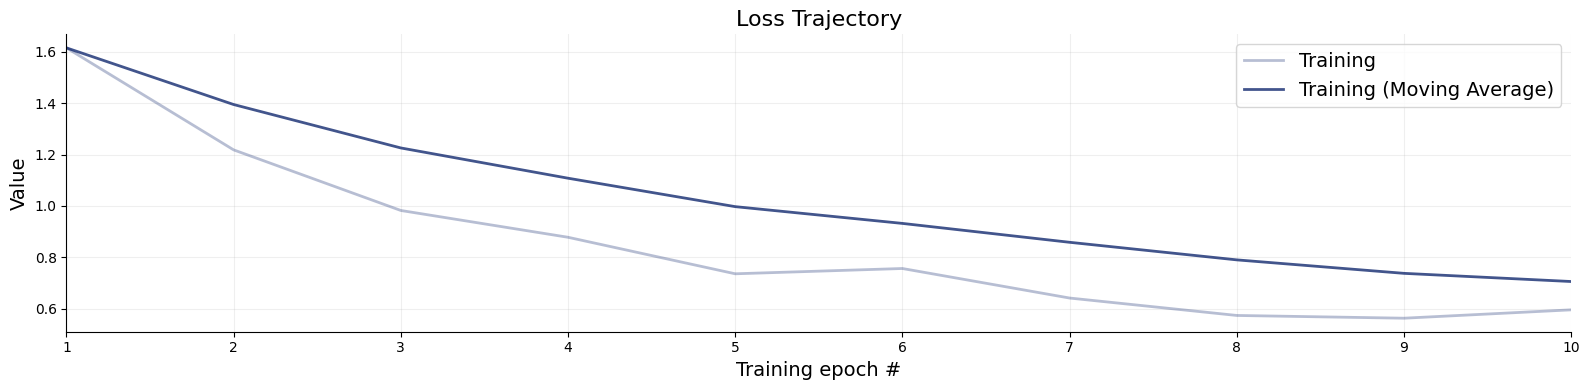

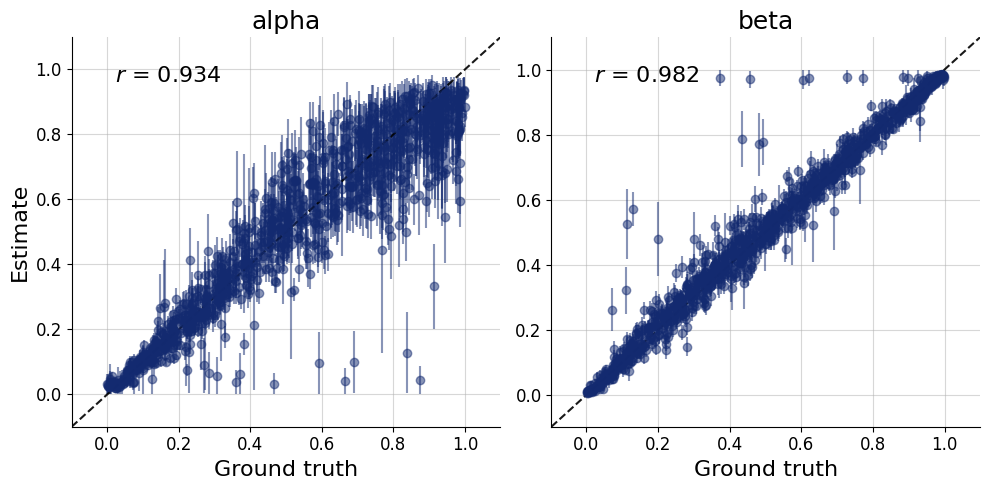

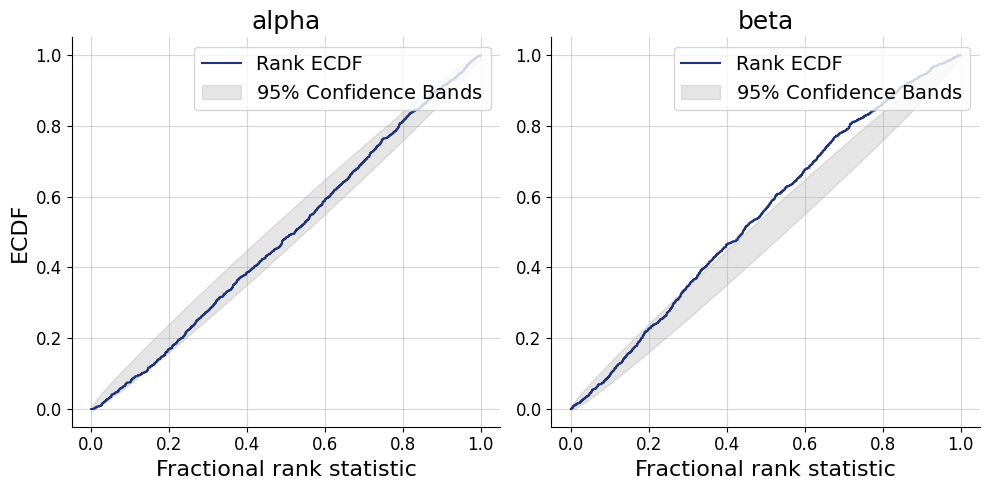

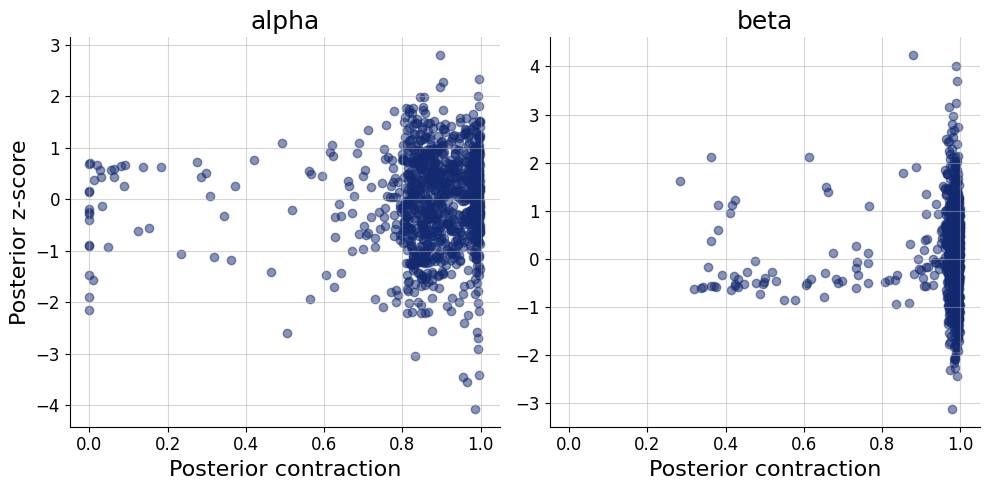

In [6]:
test_data = simulator.sample(1000)
figs = workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

We use the data from three participants by Rubin et al. (1999) as
reported by Lee & Wagenmakers (2013).

In [7]:
k = [[18, 18, 16, 13, 9, 6, 4, 4, 4],
     [17, 13,  9,  6, 4, 4, 4, 4, 4],
     [14, 10,  6,  4, 4, 4, 4, 4, 4]]

inference_data = dict(k=np.array(k)[np.newaxis])

In [8]:
samples=workflow.sample(num_samples=2000, conditions=inference_data)

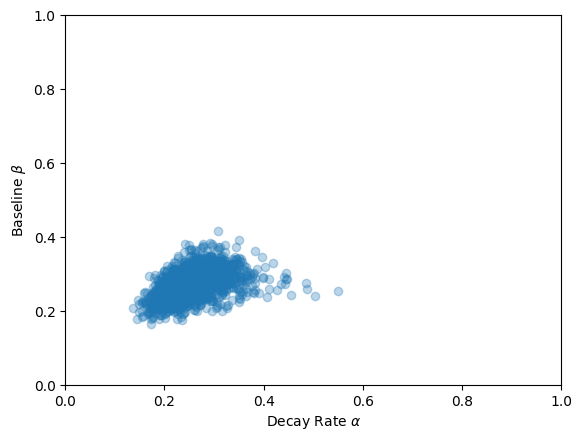

In [15]:
plt.scatter(
    x=samples["alpha"], 
    y=samples["beta"], 
    alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Decay Rate $\\alpha$")
plt.ylabel("Baseline $\\beta$")
None

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.

Rubin, D. C., Hinton, S., & Wenzel, A. (1999). The precise time course
of retention. *Journal of Experimental Psychology: Learning, Memory, and
Cognition*, *25*(5), 1161.